# Import function

In [1]:
import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Import data and split data to training and testing dataset with ShuffleSplit

In [2]:
# normalize labels
def LabelEncoder_data(data):
    typeseries = data.dtypes
    lbl = preprocessing.LabelEncoder()
    for i in typeseries.index:
        if typeseries[i] == 'object':
            data[i] = lbl.fit_transform(data[i].astype(str))
    return data

#  StandardScaler and transforms the data 
def scale_data(unscaled_data):
    scaler = StandardScaler()
    scaler.fit(unscaled_data)
    scaled_data = scaler.transform(unscaled_data)
    return scaled_data

# get features and targets
def target_data(data):
    data_y = data['discussion'].copy()
    data_x = data.drop('discussion',axis=1)
    data_x_scaled = scale_data(data_x)
    return data_x_scaled,data_y 

# use StratifiedShuffleSplit to get indices for train and test dataset
from sklearn.model_selection import StratifiedShuffleSplit
def shufflesplit_data(data_x_scaled,data_y):
    # use strat. shuffle split to get indices for test and training data 
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=123)
    sss.get_n_splits(data_x_scaled, data_y)
    return sss


# get train and test dataset from ShuffleSplited data
def train_test_data(sss):
    for train_index, test_index in sss.split(data_x_scaled, data_y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        x_train, x_test = data_x_scaled[train_index], data_x_scaled[test_index]
        y_train, y_test = data_y[train_index], data_y[test_index]
    return x_train,x_test,y_train,y_test


def import_data(data):
    LabelEncodeData=LabelEncoder_data(data)
    data_x_scaled,data_y =target_data(LabelEncodeData)
    return data_x_scaled,data_y 

# Three machine learning algorithms are conducted

## 1. Deicision Tree Classifier

In [3]:
# find the best combination of three paramters
from sklearn.model_selection import StratifiedShuffleSplit
def SearchCV():    
    # set the range of parameters searching
    param_grid = {
        'max_depth': np.arange(2, 13),
        'min_samples_leaf': np.arange(3, 10),
        'min_samples_split': np.arange(8, 15)}

    clf_dt = tree.DecisionTreeClassifier(criterion='gini', random_state=123)
    GS = GridSearchCV(clf_dt, param_grid, cv=sss)
    GS.fit(data_x_scaled, data_y)
    
    print(GS.best_params_)
    print(GS.best_score_)
    max_depth = GS.best_params_['max_depth']
    min_samples_leaf = GS.best_params_['min_samples_leaf']
    min_samples_split = GS.best_params_['min_samples_split']
    return max_depth, min_samples_leaf, min_samples_split

In [4]:
# train the models and get the mean score of cross validation

def Classifier(data_x_scaled, data_y,max_depth,min_samples_leaf,min_samples_split,sss):
    dtc = DecisionTreeClassifier(criterion="gini", random_state=123, splitter="best",max_depth=max_depth,\
                                 min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    score_dtc = cross_val_score(dtc, data_x_scaled, data_y, cv=sss)
    print("%0.3f accuracy with a standard deviation of %0.3f" % (score_dtc.mean(), score_dtc.std()))
    return dtc

In [5]:
if __name__=='__main__':
    # read audio file
    csv_file_discussion = "data/Sample_discussion.csv"
    data= pd.read_csv(csv_file_discussion, index_col=0,low_memory = False)

    # import audio data
    dataset = data.drop(labels=['uri',"timestamp"],axis=1)
    labels = ['Feature1','Feature2','Feature3','Feature4','Feature5','Feature6',\
              'Feature7','Feature8','Feature9','Feature10','Feature11','Feature12',\
              'Feature13','Feature14','Feature15','Feature16']
    
    data_x_scaled, data_y = import_data(dataset)
    
    # shuffle split the dataset
    sss = shufflesplit_data(data_x_scaled, data_y)
    max_depth, min_samples_leaf,min_samples_split = SearchCV()
    
    # train model and get the mean score of test dataset
    dtc = Classifier(data_x_scaled,data_y,max_depth,min_samples_leaf,min_samples_split,sss)

{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 8}
0.821111111111111
0.821 accuracy with a standard deviation of 0.030


In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

# use strat. shuffle split to get indices for test and training data 
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=123)
sss.get_n_splits(data_x_scaled, data_y)
for train_index, test_index in sss.split(data_x_scaled, data_y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data_x_scaled[train_index], data_x_scaled[test_index]
    y_train, y_test = data_y[train_index], data_y[test_index]

In [7]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion="gini",random_state=123,splitter="best",max_depth=8,min_samples_split=3,min_samples_leaf=3)
dtc.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=3,
                       random_state=123)

In [8]:
# get the graph of Decision Tree
from six import StringIO
import pydot

dot_data = StringIO()
feature_name=[ 'feature27','feature28','feature39','feature45','feature46','feature55','feature58',\
              'feature61','feature63','feature67','feature68','feature69','feature70','feature71',\
              'feature72','feature79']
class_name=['debate', 'narration']
graph_data=tree.export_graphviz(dtc, out_file=dot_data, feature_names=feature_name,\
                                class_names=class_name, filled=True, rounded=True, special_characters=True)
(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())
graph.write_png('DiscussionTreePlot.png')

Text(0.5, 1.0, 'confusion matrix of test')

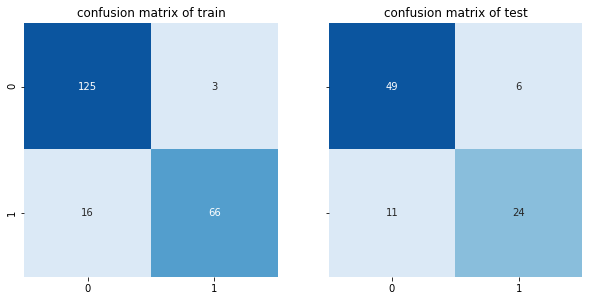

In [9]:
# the confusion matrix of train and test dataset
import matplotlib.pyplot as plt
import seaborn as sns
cn_tc_train = confusion_matrix(y_train, dtc.predict(x_train))
cn_tc_test = confusion_matrix(y_test, dtc.predict(x_test))

%matplotlib inline
f,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,10))

g1 = sns.heatmap(cn_tc_train, cmap = sns.color_palette("Blues"), annot=True,fmt='.0f', ax=ax1,square=True,cbar=False)
g2 = sns.heatmap(cn_tc_test, cmap = sns.color_palette("Blues"), annot=True,fmt='.0f',ax=ax2,square=True,cbar=False)

ax1.set_title('confusion matrix of train')
ax2.set_title('confusion matrix of test')

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_train,dtc.predict(x_train)))
print('----------------------------------------------------------')
print(classification_report(y_test,dtc.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       128
           1       0.96      0.80      0.87        82

    accuracy                           0.91       210
   macro avg       0.92      0.89      0.90       210
weighted avg       0.91      0.91      0.91       210

----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        55
           1       0.80      0.69      0.74        35

    accuracy                           0.81        90
   macro avg       0.81      0.79      0.80        90
weighted avg       0.81      0.81      0.81        90



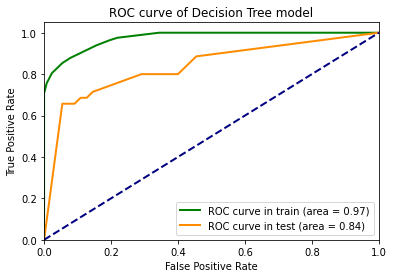

In [11]:
# the ROC curve of training and testing dataset
from sklearn.metrics import roc_curve

y_score_train_dtc = dtc.predict_proba(x_train)
fpr_train_dtc, tpr_train_dtc, _ = roc_curve(y_train, y_score_train_dtc[:,1])
y_score_test_dtc = dtc.predict_proba(x_test)
fpr_test_dtc, tpr_test_dtc, _ = roc_curve(y_test, y_score_test_dtc[:,1])

plt.figure()
lw = 2
roc_auc_train_dtc = auc(fpr_train_dtc, tpr_train_dtc)
roc_auc_test_dtc = auc(fpr_test_dtc, tpr_test_dtc)
plt.plot(fpr_train_dtc, tpr_train_dtc, color='green',lw=lw, 
             label='ROC curve in train (area = %0.2f)' % roc_auc_train_dtc)
plt.plot(fpr_test_dtc, tpr_test_dtc, color='darkorange',lw=lw, 
             label='ROC curve in test (area = %0.2f)' % roc_auc_test_dtc)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')

plt.xlim([0, 1.0])
plt.ylim([0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Decision Tree model')
plt.legend(loc="lower right")
plt.show()  


# 2、Randrom Forest Classifier

In [12]:
# find the best combination of max_depth and n_estimators
def finding_parameter(data_x_scaled, data_y, sss):
    # set the range of finding estimator_number and max_depth
    estimator_number = np.arange(20,27,1)
    depth = np.arange(3,15,1)
    ScoreAll=[]
    Scorenum=[]
    Scorenum_array=[]
    for num in estimator_number:
        Scorenum=[]
        for d in depth:
            clf = RandomForestClassifier(n_estimators=num, max_depth=d,random_state=123,oob_score=True,\
                                         criterion='gini',max_features='sqrt')
            score = cross_val_score(clf, data_x_scaled, data_y, cv=sss).mean()
            ScoreAll.append([d, num, score])
            Scorenum.append(score)
        Scorenum_array.append(np.array(Scorenum))
   
    ScoreAll = np.array(ScoreAll) 
    # get the position of the best combination and the score
    max_score = np.where(ScoreAll == np.max(ScoreAll[:, 2]))  
    print("the best depth, the best estimator_number and the score:", ScoreAll[max_score[0],0],ScoreAll[max_score[0],1],ScoreAll[max_score])

    f, ax = plt.subplots(1, 1, figsize=(24, 10))
    cax = ax.matshow( Scorenum_array, interpolation='nearest')
    f.colorbar(cax)
    ax.set_xticks(range(0,len(depth)))
    ax.set_yticks(range(0,len(estimator_number)))
    ax.set_xticklabels(depth.tolist()) 
    ax.set_yticklabels(estimator_number.tolist())
    plt.xlabel('max depth')
    plt.ylabel('estimator_number')
    plt.show()


In [13]:
# GridSearchCV to find the best combination of max_depth and n_estimators
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score

def SearchCV(data_x_scaled, data_y):  
    param_grid = {
        'max_depth': np.arange(2, 18),
        'n_estimators': np.arange(20, 30),
        }
    clf_rf = RandomForestClassifier(oob_score=True,criterion='gini',max_features='sqrt',random_state=123)
    
    # use GredSearchCV to find the best combination of parameters
    GS = GridSearchCV(clf_rf, param_grid, cv=sss)
    GS.fit(data_x_scaled, data_y)
    print(GS.best_params_)
    print(GS.best_score_)
    max_depth = GS.best_params_['max_depth']
    n_estimators = GS.best_params_['n_estimators']
 
    return max_depth, n_estimators

In [14]:
# train the models and get the mean score of cross validation
from sklearn.tree import DecisionTreeClassifier

def RF_Classifier(data_x_scaled, data_y,max_depth,n_estimators,sss):
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,\
                                      random_state=123,criterion='gini',max_features='sqrt',n_jobs=-1)
    score_rf = cross_val_score(rf, data_x_scaled, data_y, cv=sss)
    print("%0.3f accuracy with a standard deviation of %0.3f" % (score_rf.mean(), score_rf.std()))
    return rf

the best depth, the best estimator_number and the score: [6.] [24.] [0.79666667]


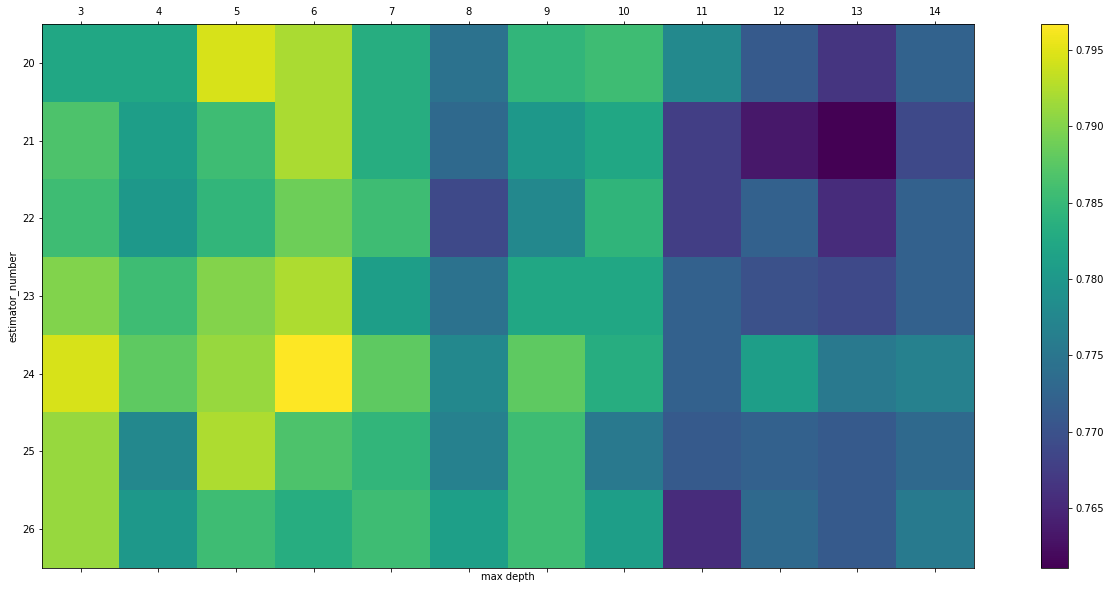

{'max_depth': 6, 'n_estimators': 24}
0.7966666666666665
0.797 accuracy with a standard deviation of 0.041


In [15]:
# find the best combination of parameters and analyse the effect of different parameters on mean score
if __name__=='__main__':
    # read audio file
    csv_file_discussion = "data/Sample_discussion.csv"
    data= pd.read_csv(csv_file_discussion, index_col=0,low_memory = False)
    
    # import audio data
    
    dataset = data.drop(labels=['uri',"timestamp"],axis=1)
    labels = ['Laughter','ContinBellyLaugh','ContinLaughter','ContinGiggle',\
        'ContinCheering','ContinApplause','ContinExcitingMusic']
    data_x_scaled, data_y  = import_data(dataset)
    
    # shuffle split the dataset
    sss = shufflesplit_data(data_x_scaled, data_y)
    finding_parameter(data_x_scaled, data_y, sss)
    max_depth, n_estimators = SearchCV(data_x_scaled, data_y)
    
    # train model and get the mean score of test dataset
    rf= RF_Classifier(data_x_scaled,data_y,max_depth,n_estimators,sss)


### Train Random Forest classifier with the best combination of parameters and get the performance of the model

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

# use strat. shuffle split to get indices for test and training data 
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=123)
sss.get_n_splits(data_x_scaled, data_y)
for train_index, test_index in sss.split(data_x_scaled, data_y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data_x_scaled[train_index], data_x_scaled[test_index]
    y_train, y_test = data_y[train_index], data_y[test_index]

training accuracy (depth: 2 ): 0.8142857142857143
test accuracy (depth: 2 ): 0.8333333333333334
training accuracy (depth: 3 ): 0.8428571428571429
test accuracy (depth: 3 ): 0.8444444444444444
training accuracy (depth: 4 ): 0.8666666666666667
test accuracy (depth: 4 ): 0.8444444444444444
training accuracy (depth: 5 ): 0.9
test accuracy (depth: 5 ): 0.8111111111111111
training accuracy (depth: 6 ): 0.9142857142857143
test accuracy (depth: 6 ): 0.8444444444444444
training accuracy (depth: 7 ): 0.9142857142857143
test accuracy (depth: 7 ): 0.8666666666666667
training accuracy (depth: 8 ): 0.919047619047619
test accuracy (depth: 8 ): 0.8333333333333334
training accuracy (depth: 9 ): 0.9285714285714286
test accuracy (depth: 9 ): 0.8444444444444444
training accuracy (depth: 10 ): 0.9285714285714286
test accuracy (depth: 10 ): 0.8555555555555555
training accuracy (depth: 11 ): 0.9285714285714286
test accuracy (depth: 11 ): 0.8555555555555555
training accuracy (depth: 12 ): 0.9285714285714286
t

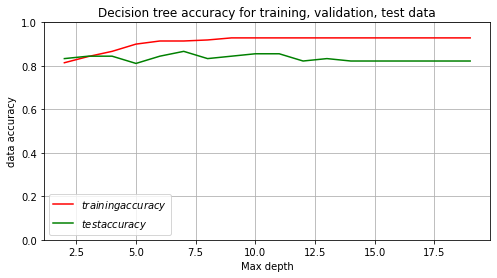

In [17]:
depth = range(2,20,1)
train_accuracy = []
valid_accuracy = []
test_accuracy = []
for d in depth:
    model_dt = RandomForestClassifier(n_estimators=24, max_depth=d,random_state=123,oob_score=True,criterion='gini',max_features='sqrt')
    model_dt.fit(x_train, y_train)
    
    train_score = model_dt.score(x_train, y_train)
    train_accuracy.append(train_score)
    print('training accuracy (depth:',d,'):',train_score)

    test_score = model_dt.score(x_test, y_test)
    test_accuracy.append(test_score)
    print('test accuracy (depth:',d,'):',test_score)
    
plt.figure(figsize=(8,4))
plt.plot(depth,train_accuracy,label='$training accuracy$',color='red')
plt.plot(depth,test_accuracy,label='$test accuracy$',color='green')
plt.xlabel('Max depth')
plt.ylabel('data accuracy')
plt.ylim((0, 1))
plt.title('Decision tree accuracy for training, validation, test data')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
print("random forest")
rfc = RandomForestClassifier(n_estimators=24, max_depth=6,random_state=123,oob_score=True,criterion='gini',max_features='sqrt')
rfc.fit(x_train, y_train)

random forest


RandomForestClassifier(max_depth=6, max_features='sqrt', n_estimators=24,
                       oob_score=True, random_state=123)

Text(0.5, 1.0, 'confusion matrix of test')

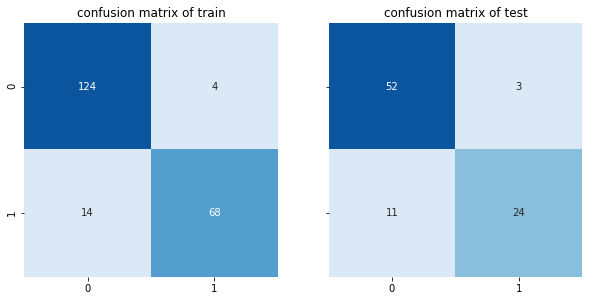

In [19]:
# the confusion matrix of train and test dataset
import matplotlib.pyplot as plt
import seaborn as sns
cn_tc_train = confusion_matrix(y_train, rfc.predict(x_train))
cn_tc_test = confusion_matrix(y_test, rfc.predict(x_test))

%matplotlib inline
f,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,10))

g1 = sns.heatmap(cn_tc_train, cmap = sns.color_palette("Blues"), annot=True,fmt='.0f', ax=ax1,square=True,cbar=False)
g2 = sns.heatmap(cn_tc_test, cmap = sns.color_palette("Blues"), annot=True,fmt='.0f',ax=ax2,square=True,cbar=False)

ax1.set_title('confusion matrix of train')
ax2.set_title('confusion matrix of test')

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_train,rfc.predict(x_train)))
print('----------------------------------------------------------')
print(classification_report(y_test,rfc.predict(x_test)))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       128
           1       0.94      0.83      0.88        82

    accuracy                           0.91       210
   macro avg       0.92      0.90      0.91       210
weighted avg       0.92      0.91      0.91       210

----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        55
           1       0.89      0.69      0.77        35

    accuracy                           0.84        90
   macro avg       0.86      0.82      0.83        90
weighted avg       0.85      0.84      0.84        90



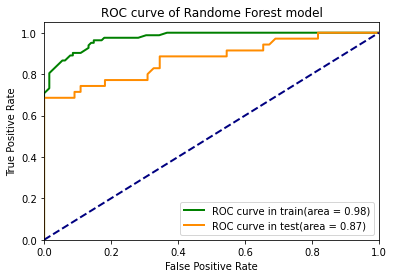

In [21]:
# the ROC curve of training and testing dataset
from sklearn.metrics import roc_curve
y_score_train_rfc = rfc.predict_proba(x_train)
fpr_train_rfc, tpr_train_rfc, _ = roc_curve(y_train, y_score_train_rfc[:,1])
y_score_test_rfc = rfc.predict_proba(x_test)
fpr_test_rfc, tpr_test_rfc, _ = roc_curve(y_test, y_score_test_rfc[:,1])

plt.figure()
lw = 2
# get the ROC of train
roc_auc_train_rfc = auc(fpr_train_rfc, tpr_train_rfc)
# get the ROC of test
roc_auc_test_rfc = auc(fpr_test_rfc, tpr_test_rfc)
# plot
plt.plot(fpr_train_rfc, tpr_train_rfc, color='green',lw=lw, 
             label='ROC curve in train(area = %0.2f)' % roc_auc_train_rfc)
plt.plot(fpr_test_rfc, tpr_test_rfc, color='darkorange',lw=lw, 
             label='ROC curve in test(area = %0.2f)' % roc_auc_test_rfc)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')

plt.xlim([0, 1.0])
plt.ylim([0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Randome Forest model')
plt.legend(loc="lower right")
plt.show()  

# 3. SVM

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

CScale = range(-15,15,1)
gammaScale=range(-15,15,1)

CScale = [2 ** i for i in CScale]
gammaScale = [2 ** i for i in gammaScale]

parameters = dict(kernel=['rbf'],gamma=gammaScale, C=CScale)
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=123)
SVC=svm.SVC(decision_function_shape='ovo',probability=True, class_weight='balanced',random_state=123)

svm = GridSearchCV(estimator=SVC, param_grid=parameters, cv=sss,n_jobs=-1)
svm.fit(data_x_scaled, data_y)

print('The parameters of the best model are: ')
print(svm.best_params_)
print('The best score is: ')
print(svm.best_score_ )
print('The mean score is: ')
print(cross_val_score(svm, data_x_scaled, data_y, cv=sss).mean())

The parameters of the best model are: 
{'C': 1, 'gamma': 0.125, 'kernel': 'rbf'}
The best score is: 
0.7466666666666667
The mean score is: 
0.7155555555555555


### Use the parameters to train SVM model and get the performance of the model

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

# use strat. shuffle split to get indices for test and training data 
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=123)
sss.get_n_splits(data_x_scaled, data_y)
for train_index, test_index in sss.split(data_x_scaled, data_y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data_x_scaled[train_index], data_x_scaled[test_index]
    y_train, y_test = data_y[train_index], data_y[test_index]

In [24]:
print("SVM Classifier")
from sklearn import svm

svm_clf = svm.SVC(kernel='rbf', C=1, gamma=0.125, probability=True, class_weight='balanced',random_state=123)
svm_clf.fit(x_train,y_train)

SVM Classifier


SVC(C=1, class_weight='balanced', gamma=0.125, probability=True,
    random_state=123)

Text(0.5, 1.0, 'confusion matrix of test')

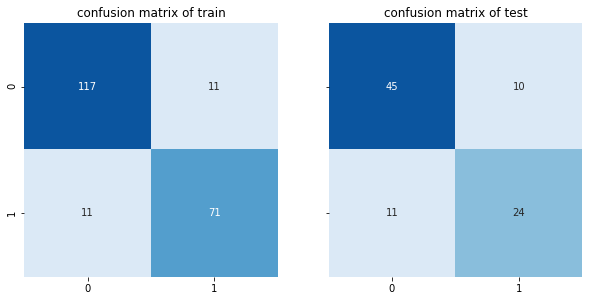

In [25]:
# the confusion matrix of train and test dataset
import matplotlib.pyplot as plt
import seaborn as sns
cn_tc_train = confusion_matrix(y_train, svm_clf.predict(x_train))
cn_tc_test = confusion_matrix(y_test, svm_clf.predict(x_test))

%matplotlib inline
f,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,10))

g1 = sns.heatmap(cn_tc_train, cmap = sns.color_palette("Blues"), annot=True,fmt='.0f', ax=ax1,square=True,cbar=False)
g2 = sns.heatmap(cn_tc_test, cmap = sns.color_palette("Blues"), annot=True,fmt='.0f',ax=ax2,square=True,cbar=False)

ax1.set_title('confusion matrix of train')
ax2.set_title('confusion matrix of test')

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_train,svm_clf.predict(x_train)))
print('----------------------------------------------------------')
print(classification_report(y_test,svm_clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       128
           1       0.87      0.87      0.87        82

    accuracy                           0.90       210
   macro avg       0.89      0.89      0.89       210
weighted avg       0.90      0.90      0.90       210

----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        55
           1       0.71      0.69      0.70        35

    accuracy                           0.77        90
   macro avg       0.75      0.75      0.75        90
weighted avg       0.77      0.77      0.77        90



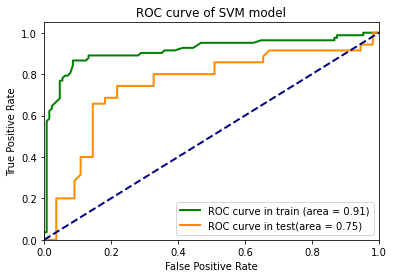

In [27]:
from sklearn.metrics import roc_curve
y_score_train_svm = svm_clf .predict_proba(x_train)
fpr_train_svm, tpr_train_svm, _ = roc_curve(y_train, y_score_train_svm[:,1])
y_score_test_svm = svm_clf .predict_proba(x_test)
fpr_test_svm, tpr_test_svm, _ = roc_curve(y_test, y_score_test_svm[:,1])

plt.figure()
lw = 2
# get the ROC of train dataset
roc_auc_train_svm = auc(fpr_train_svm,tpr_train_svm)
# get the ROC of test dataset
roc_auc_test_svm = auc(fpr_test_svm,tpr_test_svm)
# plot
plt.plot(fpr_train_svm, tpr_train_svm, color='green',lw=lw, 
             label='ROC curve in train (area = %0.2f)' % roc_auc_train_svm)
plt.plot(fpr_test_svm, tpr_test_svm, color='darkorange',lw=lw, 
             label='ROC curve in test(area = %0.2f)' % roc_auc_test_svm)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')

plt.xlim([0, 1.0])
plt.ylim([0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of SVM model')
plt.legend(loc="lower right")
plt.show()  


## Compare the ROC curves of test dataset of three models

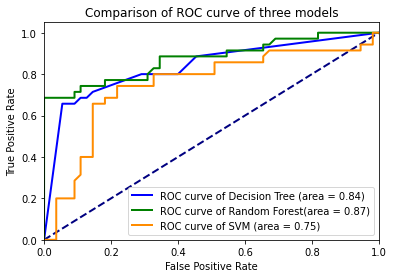

In [28]:
from sklearn.metrics import roc_curve

plt.figure()
lw = 2
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')

plt.plot(fpr_test_dtc, tpr_test_dtc, color='blue',lw=lw, 
             label='ROC curve of Decision Tree (area = %0.2f)' % roc_auc_test_dtc)
plt.plot(fpr_test_rfc, tpr_test_rfc, color='green',lw=lw, 
             label='ROC curve of Random Forest(area = %0.2f)' % roc_auc_test_rfc)
plt.plot(fpr_test_svm, tpr_test_svm, color='darkorange',lw=lw, 
             label='ROC curve of SVM (area = %0.2f)' % roc_auc_test_svm)

plt.xlim([0, 1.0])
plt.ylim([0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC curve of three models')
plt.legend(loc="lower right")
plt.show()  